# 探索 GoBike 数据
## by Ivy

## 初步探索

> 该数据集包含有关在旧金山湾区的自行车共享系统中的单次骑行信息。下载地址为：https://s3.amazonaws.com/baywheels-data/index.html 。本次分析只下载了 2018 年 1 - 12 月的数据。每条信息都是匿名的，其中包括:
- 骑行时长
- 开始时间
- 结束时间
- 开始站点 ID
- 开始站点名称
- 开始站点纬度
- 开始站点经度
- 结束站点 ID
- 结束站点名称
- 结束站点纬度
- 结束站点经度
- 车辆 ID
- 用户类型：
    1. 会员："Subscriber" 或者 "Member"
    2. 散客："Customer" 或者 "Casual"
- 会员出生年份
- 会员性别
- 是否参与 Bike Share for All 计划

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
pd.set_option('max_colwidth',200)
%matplotlib inline

> 2018 年数据集有多个，每个月一个 csv 文件，所以这里先把 2018 年的数据进行合并，创建一个新的 `2018-fordgobike-tripdata.csv` 数据集。

因为数据集太大，提交的是 zip 文件，初始需要运行以下代码获取完整数据：

In [3]:
def unzip_csv():
    '''
    将 zip 文件夹中的所有 zip 文件都解压到当前目录下
    并返回解压后的 csv 文件名列表
    '''
    zip_list = os.listdir('zip/')
    # 解压所有压缩包
    csv_list = [] 
    for file in zip_list:
        if file[-4:] == '.zip':
            with zipfile.ZipFile('zip/'+file, 'r') as myzip:
                csv_file = myzip.namelist()[0]
                csv_list.append(csv_file)
                myzip.extract(csv_file)
    return csv_list

def append_csv(csv_list):
    '''
    读取 csv_list 中的每一个 csv 文件，将所有的数据集追加到一起
    返回最终的 df
    '''
    # 将数据集合并到一起
    df = pd.DataFrame()
    df_shape = 0
    for c in csv_list:
        df_month = pd.read_csv(c)
        df_shape += df_month.shape[0]
        df = df.append(df_month)
    return df

In [4]:
if '2018-fordgobike-tripdata.csv' not in os.listdir(): # 判断当前工作目录是否存在目标数据集
    csv_list = unzip_csv() # 解压所有 zip 文件
    df = append_csv(csv_list) # 将所有 csv 文件读取并合并到一个数据集
    df.to_csv('2018-fordgobike-tripdata.csv',index=False) # 保存为一个 2018 年的数据集
else:
    df = pd.read_csv('2018-fordgobike-tripdata.csv')

> 加载数据集，并通过以下问题描述数据属性。
尝试通过这部分内容获得探索灵感。

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863721 entries, 0 to 1863720
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 227.5+ MB


In [6]:
# 每列数据的缺失值比例
df.isna().sum()/df.shape[0]

duration_sec               0.000000
start_time                 0.000000
end_time                   0.000000
start_station_id           0.006316
start_station_name         0.006316
start_station_latitude     0.000000
start_station_longitude    0.000000
end_station_id             0.006316
end_station_name           0.006316
end_station_latitude       0.000000
end_station_longitude      0.000000
bike_id                    0.000000
user_type                  0.000000
member_birth_year          0.059407
member_gender              0.059219
bike_share_for_all_trip    0.000000
dtype: float64

因为这个数据集的量非常大，缺失值比例都比较小，所以直接将所有包含缺失值的数据删除处理。

In [7]:
df.dropna(inplace=True)
df.shape[0]

1741556

In [8]:
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,75284,2018-01-31 22:52:35.2390,2018-02-01 19:47:19.8240,120.0,Mission Dolores Park,37.761420,-122.426435,285.0,Webster St at O'Farrell St,37.783521,-122.431158,2765,Subscriber,1986.0,Male,No
2,71576,2018-01-31 14:23:55.8890,2018-02-01 10:16:52.1160,304.0,Jackson St at 5th St,37.348759,-121.894798,296.0,5th St at Virginia St,37.325998,-121.877120,3039,Customer,1996.0,Male,No
4,39966,2018-01-31 19:52:24.6670,2018-02-01 06:58:31.0530,74.0,Laguna St at Hayes St,37.776435,-122.426244,19.0,Post St at Kearny St,37.788975,-122.403452,617,Subscriber,1991.0,Male,No
6,453,2018-01-31 23:53:53.6320,2018-02-01 00:01:26.8050,110.0,17th & Folsom Street Park (17th St at Folsom St),37.763708,-122.415204,134.0,Valencia St at 24th St,37.752428,-122.420628,3571,Subscriber,1988.0,Male,No
7,180,2018-01-31 23:52:09.9030,2018-01-31 23:55:10.8070,81.0,Berry St at 4th St,37.775880,-122.393170,93.0,4th St at Mission Bay Blvd S,37.770407,-122.391198,1403,Subscriber,1980.0,Male,No


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1741556 entries, 0 to 1863719
Data columns (total 16 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
bike_share_for_all_trip    object
dtypes: float64(7), int64(2), object(7)
memory usage: 225.9+ MB


初步清理各列错误的数据类型：

- member_birth_year 应该是 int 型；
- id 相关列应该是字符串类型；
- time 相关列应该是 datetime 类型；
- bike_share_for_all_trip 应该是布尔值。

In [10]:
df['member_birth_year'] = df['member_birth_year'].astype(np.int64)

In [11]:
column_list = df.columns.tolist()

In [12]:
for c in column_list:
    if '_id' in c:
        df[c] = df[c].astype(np.int64).astype(str)
    elif '_time' in c:
        df[c] = pd.to_datetime(df[c])

In [13]:
df.replace(['Yes','No'],[True,False],inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1741556 entries, 0 to 1863719
Data columns (total 16 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           object
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             object
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    object
user_type                  object
member_birth_year          int64
member_gender              object
bike_share_for_all_trip    bool
dtypes: bool(1), datetime64[ns](2), float64(4), int64(2), object(7)
memory usage: 214.3+ MB


### 数据集结构

- `duration_sec`               int64
- `start_time`                 datetime64[ns]
- `end_time`                   datetime64[ns]
- `start_station_id`           object
- `start_station_name`         object
- `start_station_latitude`     float64
- `start_station_longitude`    float64
- `end_station_id`             object
- `end_station_name`           object
- `end_station_latitude`       float64
- `end_station_longitude`      float64
- `bike_id`                    object
- `user_type`                  object
- `member_birth_year`          int64
- `member_gender`              object
- `bike_share_for_all_trip`    bool

### 数据集中感兴趣的列主要有：

- 是否订阅会员服务（`user_type`），与哪些特征相关？

### 你认为数据集中的哪些特征有助于对感兴趣的特征进行探索？

> `duration_sec`、`start_time`  、`member_birth_year`、`member_gender`、`bike_share_for_all_trip`

## 单变量探索

> 对单一变量进行探索，如果发现异常值，则进行深入清理。

In [15]:
df_copy = df[['duration_sec','start_time','member_birth_year','member_gender','bike_share_for_all_trip','user_type']].copy()

#### 骑行时长分布

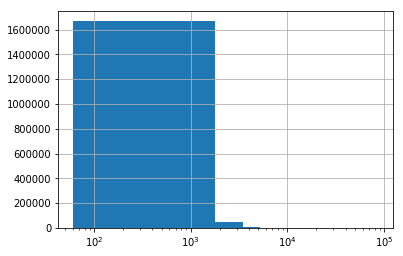

In [16]:
df_copy.duration_sec.hist(bins=50)
plt.xscale('log');

可以看到骑行时长右偏非常严重，使用 log 变换之后也不太容易观察，再详细设置一下：

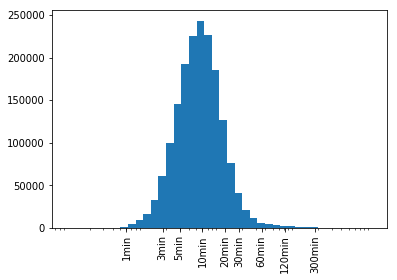

In [17]:
bin_edges = 10 ** np.arange(1, np.log10(df_copy.duration_sec.max())+0.1, 0.1)
plt.hist(df_copy.duration_sec, bins = bin_edges)
plt.xscale('log')
tick_locs = [60, 180, 300, 600, 1200, 1800, 3600, 7200, 18000]
tick_labels = ['1min','3min','5min','10min','20min','30min','60min','120min','300min']
plt.xticks(tick_locs, tick_labels, rotation=90);

可以观察到骑行时长大部分都在 1 小时以下，最多的位于 5-20 分钟的范围内，还是比较合理的。双变量探索时要探索会员与非会员分别的骑行时长分布。

#### 骑行开始时间探索

In [18]:
df_copy['start_date'] = df_copy['start_time'].dt.date
df_copy['start_week'] = df_copy['start_time'].dt.week
df_copy['start_weekday'] = df_copy['start_time'].dt.weekday
df_copy['start_hour'] = df_copy['start_time'].dt.hour
df_copy['start_month'] = df_copy['start_time'].dt.month

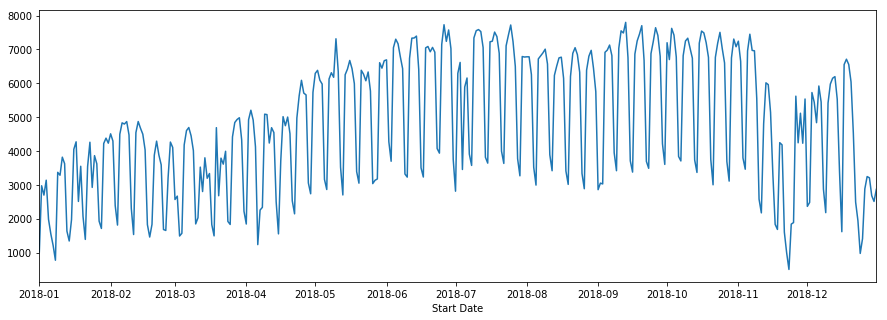

In [19]:
df_copy['start_date'].value_counts().sort_index().plot(figsize=(15,5))
plt.xlabel('Start Date');

可以看到明显的、有规律的波动，猜测是周末使用量下降导致的，看一下每周使用量是否与上面的波动相似：

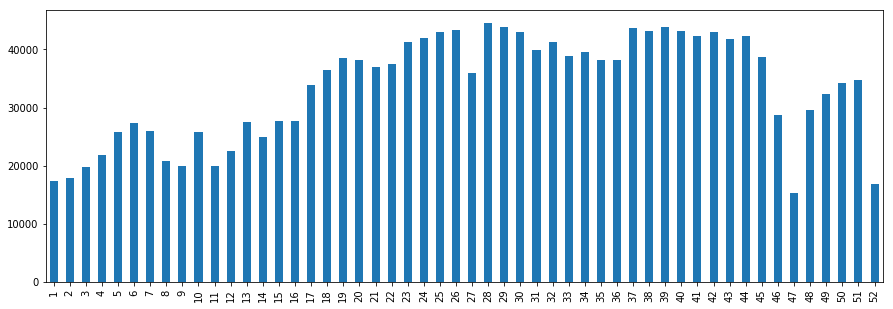

In [20]:
df_copy['start_week'].value_counts().sort_index().plot(kind='bar',figsize=(15,5));

每周的波动很可能是由于周末导致的，观察一下一周 7 天的变化情况：

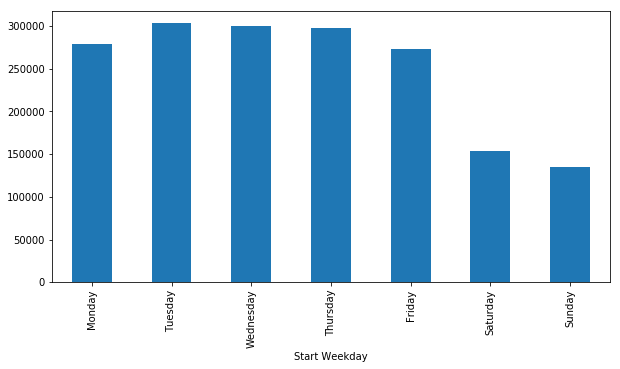

In [21]:
df_copy['start_weekday'].value_counts().sort_index().plot(kind='bar',figsize=(10,5))
# dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
weekday_name = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plt.xticks(range(0,7), weekday_name)
plt.xlabel('Start Weekday');

果然周末使用量减少很多，那么可能使用更多的是通勤的用途，可以探索一下小时的规律，看看能否与通勤挂钩：

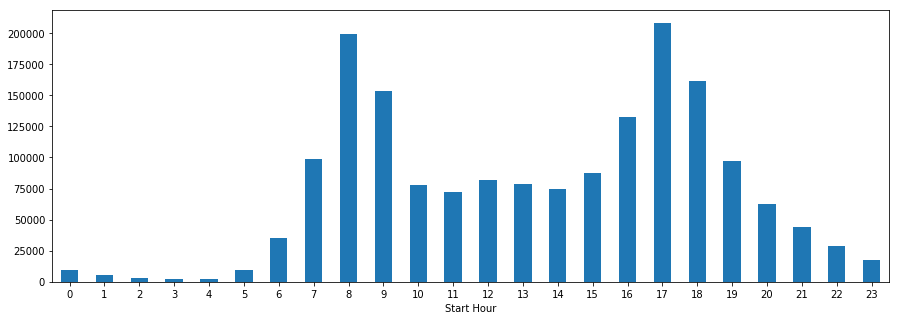

In [22]:
df_copy['start_hour'].value_counts().sort_index().plot(kind='bar',figsize=(15,5),rot=0)
plt.xticks(range(0,24), range(0,24))
plt.xlabel('Start Hour');

开始骑行的小时，可以发现明显的两个高峰，一个是 8-9 点，一个是 17-18 点，上下班高峰期。

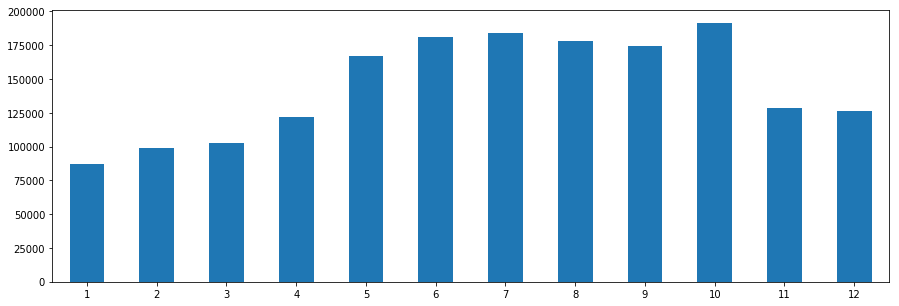

In [23]:
df_copy['start_month'].value_counts().sort_index().plot(kind='bar',figsize=(15,5),rot=0);

寒冷的月份使用量较少，5-10月使用量较多。

#### 用户类型分布

Subscriber    1542367
Customer       199189
Name: user_type, dtype: int64


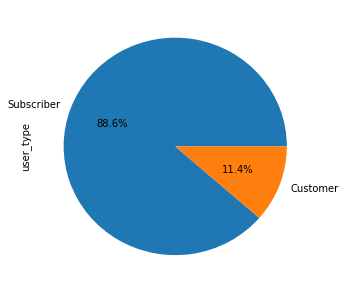

In [24]:
print(df_copy.user_type.value_counts())
df_copy.user_type.value_counts().plot(kind='pie', autopct='%.1f%%',figsize=(5,5));

In [25]:
# 创建布尔值类型的会员列，方便后续计算
df_copy['is_vip'] = df_copy['user_type'] == 'Subscriber'

In [26]:
df_copy['is_vip'].mean() #验证一下，与上面的饼图百分比一致

0.8856258426372738

大部分骑行订单来自会员账户，只有 11.4% 来自散客。

#### Bike Share for All 服务

Bike Share for All 这是一种服务方式，根据官网的介绍，似乎针对的是低收入人群，需要符合一些标准才可以申请，以下内容摘自[官网介绍](https://www.lyft.com/bikes/bay-wheels/bike-share-for-all):
> We offer all residents of the Bay Area an affordable, accessible, and fun new transportation option. Low-income residents qualify for a discounted membership.

>Bike Share for All is available to Bay Area residents ages 18 and older who qualify for Calfresh, SFMTA (Low Income) Lifeline Pass or PG&E CARE utility discount.

探索一下 2018 年这个服务的情况：

False    1580067
True      161489
Name: bike_share_for_all_trip, dtype: int64


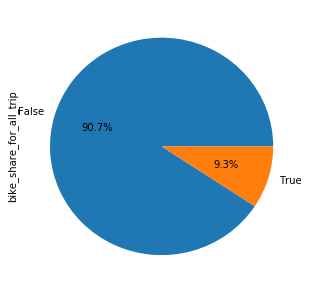

In [27]:
print(df_copy.bike_share_for_all_trip.value_counts())
df_copy.bike_share_for_all_trip.value_counts().plot(kind='pie', autopct='%.1f%%',figsize=(5,5));

只有 9.3% 的用户享用 Bike Share for All 服务。

#### 用户性别分布

Male      1279545
Female     435010
Other       27001
Name: member_gender, dtype: int64


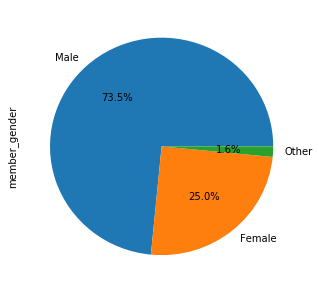

In [28]:
print(df_copy.member_gender.value_counts())
df_copy.member_gender.value_counts().plot(kind='pie', autopct='%.1f%%',figsize=(5,5));

大部分用户是男性，大约 1/4 的用户是女性，男女比例还是比较有差异性的。

#### 出生年份 / 年龄分布

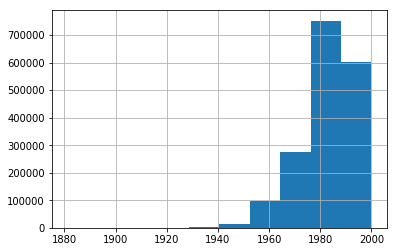

In [29]:
df_copy.member_birth_year.hist();

出生年份，其实可以转换为年龄，更容易认知。因为这些数据都是 2018 年的，所以直接用 2018 减去出生年份就是每个用户的年龄了：

In [30]:
df_copy['age'] = 2018 - df_copy['member_birth_year']

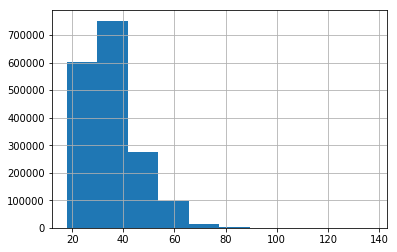

In [31]:
df_copy['age'].hist();

可以看到有一些超过 90 岁的异常值，可以打印出来观察：

In [32]:
df_copy[df_copy['age']>90]

,duration_sec,start_time,member_birth_year,member_gender,bike_share_for_all_trip,user_type,start_date,start_week,start_weekday,start_hour,start_month,is_vip,age
93,465,2018-01-31 21:56:17.633,1911,Other,False,Subscriber,2018-01-31,5,2,21,1,True,107
1065,549,2018-01-31 18:01:24.729,1911,Other,False,Subscriber,2018-01-31,5,2,18,1,True,107
1254,568,2018-01-31 17:40:47.701,1911,Other,False,Subscriber,2018-01-31,5,2,17,1,True,107
1532,658,2018-01-31 17:11:03.424,1902,Male,False,Subscriber,2018-01-31,5,2,17,1,True,116
2983,1681,2018-01-31 09:37:00.045,1911,Other,False,Subscriber,2018-01-31,5,2,9,1,True,107
3409,549,2018-01-31 09:02:28.385,1902,Male,False,Subscriber,2018-01-31,5,2,9,1,True,116
3768,1215,2018-01-31 08:17:13.815,1911,Other,False,Subscriber,2018-01-31,5,2,8,1,True,107
5343,787,2018-01-30 18:25:32.383,1911,Other,False,Subscriber,2018-01-30,5,1,18,1,True,107
6043,610,2018-01-30 17:13:48.813,1902,Male,False,Subscriber,2018-01-30,5,1,17,1,True,116
6196,1325,2018-01-30 16:48:10.170,1900,Other,False,Customer,2018-01-30,5,1,16,1,False,118


这些异常值的数量不是特别多，而且没办法判断是什么原因导致的，所以直接删除处理，只保留小于 90 岁的数据：

In [33]:
df_copy = df_copy[df_copy['age']<90]
df_copy.shape[0]

1740143

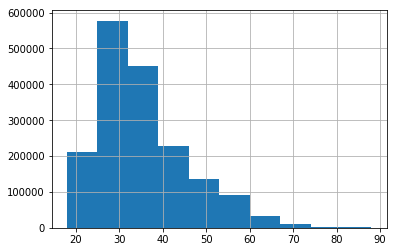

In [34]:
df_copy['age'].hist();

In [35]:
df_copy['age'].describe()

count    1.740143e+06
mean     3.487694e+01
std      1.022111e+01
min      1.800000e+01
25%      2.700000e+01
50%      3.300000e+01
75%      4.000000e+01
max      8.800000e+01
Name: age, dtype: float64

最小值是 18 岁，猜测这个共享单车系统是要求成年才可以注册的。大部分人（75%）都是 40 岁以下。

### 对于你感兴趣的变量，存在什么异常吗？需不需要执行变换操作？

> 感兴趣的变量是分类变量，其实想要探索是否会员，可以直接将其转换为布尔值，方便后续的探索

### 在你探索的特征中，是否存在异常分布？你对这些数据执行了什么整理操作？请给出整理操作的原因。

> 探索的其他特征中，年龄有一些异常，因为数据占比较小，又没有探索出异常值出现的原因，所以目前只保留了 90 以下的年龄数据。

## 双变量探索

In [52]:
def variable_visulization(df, feature):
    '''各个因素对注册会员的影响分析对比柱状图组合'''
    f, ax = plt.subplots(1,2,figsize=(16,5))
    # 左侧显示注册会员人数对比柱状图
    df.groupby([feature,'is_vip'])['is_vip'].count().unstack().plot(kind='bar',ax=ax[0])
    ax[0].set_ylabel('Number of users')
    ax[0].set_title(feature + ' VS Vip VS Count')
    # 右侧显示注册会员几率柱状图
    df.groupby(feature)['is_vip'].mean().plot(kind='bar',ax = ax[1])
    ax[1].set_ylabel('Vip Rate')
    ax[1].set_title(feature + ' VS Vip Rate')
    plt.show()

In [36]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1740143 entries, 0 to 1863719
Data columns (total 13 columns):
duration_sec               int64
start_time                 datetime64[ns]
member_birth_year          int64
member_gender              object
bike_share_for_all_trip    bool
user_type                  object
start_date                 object
start_week                 int64
start_weekday              int64
start_hour                 int64
start_month                int64
is_vip                     bool
age                        int64
dtypes: bool(2), datetime64[ns](1), int64(7), object(3)
memory usage: 162.6+ MB


#### 年龄 vs 会员

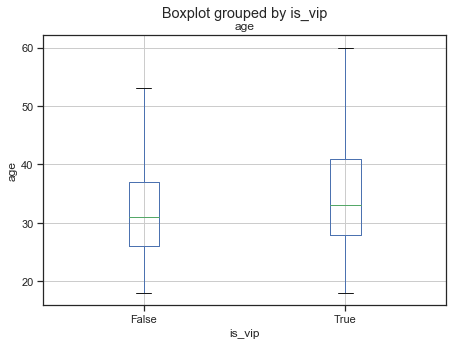

In [78]:
df_copy.boxplot(column='age',by='is_vip',showfliers=False,figsize=(7,5))
plt.ylabel('age');

In [85]:
df_copy.groupby('is_vip')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
is_vip,,,,,,,,
False,199038.0,32.903807,9.380574,18.0,26.0,31.0,37.0,88.0
True,1541105.0,35.131778,10.297155,18.0,28.0,33.0,41.0,87.0


从上面的箱线图和描述性统计信息可以看到，会员的年龄总体来说比非会员要大，均值、Q1、Q2、Q3 都是会员的值大。

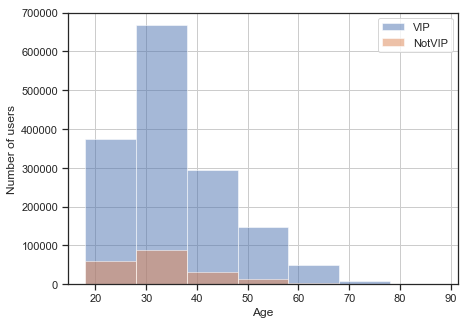

In [88]:
bins=[18,28,38,48,58,68,78,88]
df_copy[df_copy['is_vip']==True]['age'].hist(bins=bins,alpha=0.5,figsize=(7,5),label='VIP')
df_copy[df_copy['is_vip']==False]['age'].hist(bins=bins,alpha=0.5,figsize=(7,5),label='NotVIP')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Number of users');

通过直方图的对比，可以看到非会员的年龄分布较为均匀，而会员的年龄更集中在 28-38 的范围内。
#### 骑行时长 vs 会员

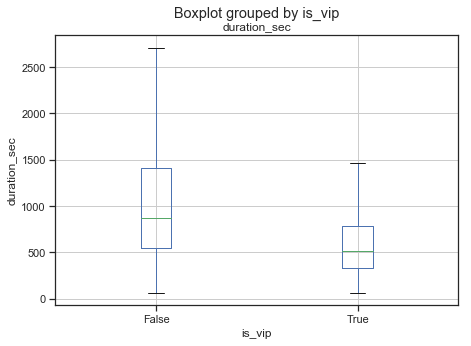

In [75]:
df_copy.boxplot(column='duration_sec',by='is_vip',showfliers=False,figsize=(7,5))
plt.ylabel('duration_sec');

In [86]:
df_copy.groupby('is_vip')['duration_sec'].describe()

,count,mean,std,min,25%,50%,75%,max
is_vip,,,,,,,,
False,199038.0,1601.146655,4304.799340,61.0,550.0,876.0,1414.0,86208.0
True,1541105.0,665.863948,1329.908973,61.0,330.0,515.0,783.0,86281.0


从上面的箱线图和描述性统计信息可以看到，会员的骑行时长相对比较短，绝大多数都在 1500 秒以下，也就是小于 25 分钟。75% 的人骑行时长都在 13 分钟以下。

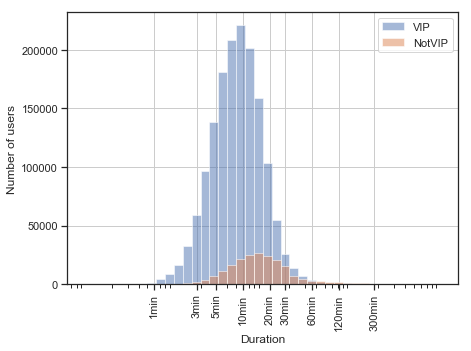

In [87]:
bin_edges = 10 ** np.arange(1, np.log10(df_copy.duration_sec.max())+0.1, 0.1)
df_copy[df_copy['is_vip']==True]['duration_sec'].hist(bins=bin_edges,alpha=0.5,figsize=(7,5),label='VIP')
df_copy[df_copy['is_vip']==False]['duration_sec'].hist(bins=bin_edges,alpha=0.5,figsize=(7,5),label='NotVIP')
plt.xscale('log')
tick_locs = [60, 180, 300, 600, 1200, 1800, 3600, 7200, 18000]
tick_labels = ['1min','3min','5min','10min','20min','30min','60min','120min','300min']
plt.legend()
plt.xticks(tick_locs, tick_labels, rotation=90)
plt.xlabel('Duration')
plt.ylabel('Number of users');

通过上方直方图对比，可以看到非会员的分布更加均匀且时长偏长，会员的时间非常集中在 3-20 分钟的范围内。
#### 会员 vs 性别

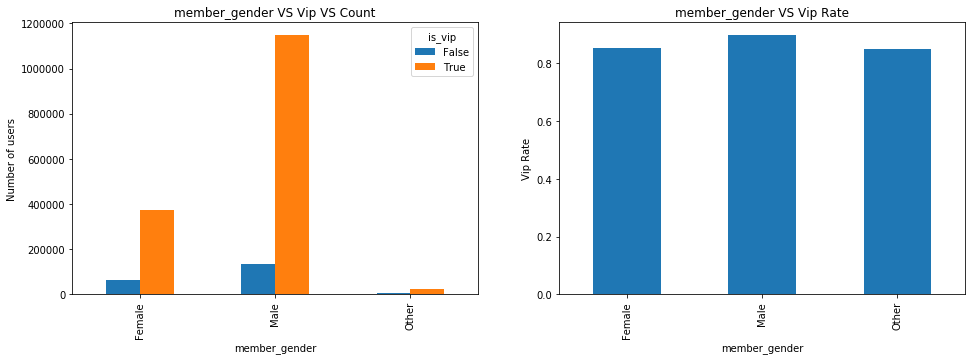

In [53]:
variable_visulization(df_copy,'member_gender')

差异不是很大，相对来说男性的会员比例稍多。
#### 会员 vs bike share for all 服务

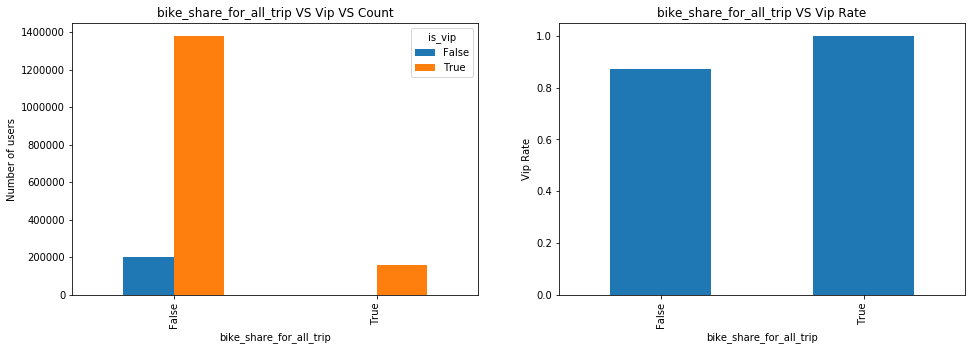

In [54]:
variable_visulization(df_copy,'bike_share_for_all_trip')

bike share for all 服务全部属于会员，应该是因为该服务也属于会员的一种。

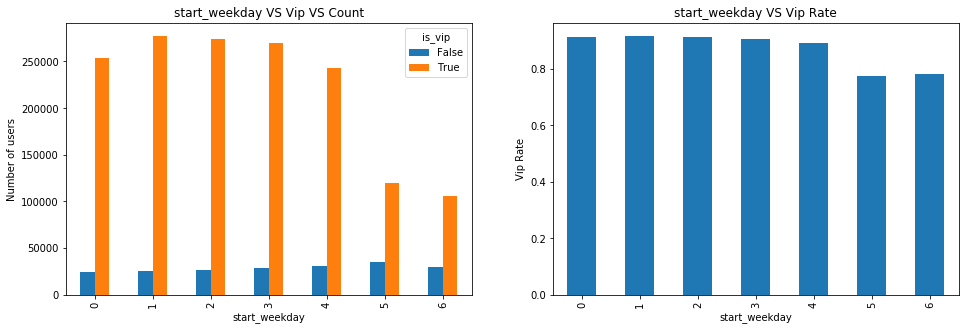

In [55]:
variable_visulization(df_copy,'start_weekday')

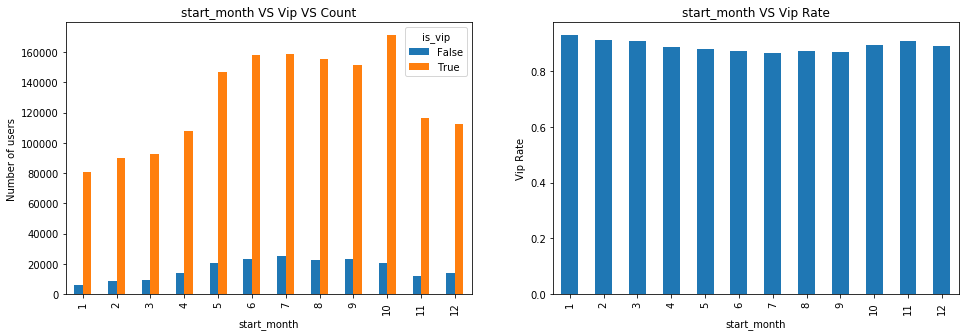

In [56]:
variable_visulization(df_copy,'start_month')

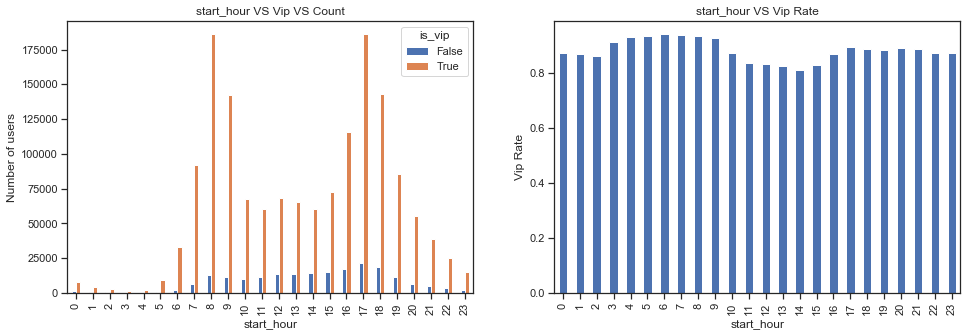

In [60]:
variable_visulization(df_copy,'start_hour')

### 讲一下你在这一部分的探索中观察到的关系，你感兴趣的变量是否有变化？

> Your answer here!

### 是否观察到其他特征（不是之前感兴趣的特征）之间的有趣关系？

> Your answer here!

## 多变量探索

> 创建三个或更多变量的图表，以进一步探索数据。确保探索是合理的，与前面的探索一脉相承。

### 讨论这一部分探索中观察到的关系。这些特征关系是否对你感兴趣的特征有帮助？ Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### 特征之间是否存在有趣的、令人惊讶的相互作用？

> Your answer here!